## Pneumonia Detection - Model Training

**Authors**: Aye Nyein Kyaw and Isiah Ketton  
**Course**: CS 171 - Machine Learning  
**Project**: Pneumonia Detection from Chest X-Ray Images

This notebook implements and trains a Convolutional Neural Network (CNN) for pneumonia detection.

We will:
1. Define the CNN architecture
2. Set up training parameters and loss functions
3. Train the model with validation monitoring
4. Save the best model checkpoint
5. Evaluate on the test set

**Prerequisites**: Run `data_preprocessing.ipynb` first to prepare the data.

In [6]:
# pip install seaborn

In [10]:
# Import Required Libraries

import os
import time
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader

Set Visualization Style

In [9]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

print("Visualization style configured")

Visualization style configured


## Load Preprocessed Data
Load the DataLoaders created in the preprocessing notebook.
**IMPORTANT**: Run `data_preprocessing.ipynb` first!

In [11]:
print("=== LOADING PREPROCESSED DATA ===")

try:
    # Method 1: Import directly if running in same session
    from data_preprocessing import train_loader, val_loader, test_loader, device
    print("DataLoaders loaded from preprocessing notebook")
    
    # Get class names from the dataset
    from data_preprocessing import train_dataset
    CLASS_NAMES = train_dataset.classes
    print(f"Class names loaded: {CLASS_NAMES}")
    
except ImportError:
    print("Could not import from preprocessing notebook.")
    print("Trying alternative loading method...")
    
    # Method 2: Load from saved config and recreate
    try:
        # Load preprocessing configuration
        with open('preprocessing_config.json', 'r') as f:
            config = json.load(f)
        
        print("Loaded preprocessing configuration")
        
        # Extract information
        IMAGE_SIZE = config['image_settings']['size']
        BATCH_SIZE = config['data_settings']['batch_size']
        CLASS_NAMES = config['class_info']['classes']
        
        # Recreate transforms
        from torchvision import transforms
        
        basic_transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        
        train_dir = config['paths']['train_dir']
        val_dir = config['paths']['val_dir']
        test_dir = config['paths']['test_dir']
        
        train_dataset = datasets.ImageFolder(train_dir, transform=basic_transform)
        val_dataset = datasets.ImageFolder(val_dir, transform=basic_transform)
        test_dataset = datasets.ImageFolder(test_dir, transform=basic_transform)
        
        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        print("DataLoaders recreated from config")
        
    except Exception as e:
        print(f"Error: {e}")
        print("\nPlease run 'data_preprocessing.ipynb' first!")
        raise


=== LOADING PREPROCESSED DATA ===
Could not import from preprocessing notebook.
Trying alternative loading method...
Loaded preprocessing configuration
DataLoaders recreated from config


## Define the CNN Architecture
We'll create a CNN with 4 convolutional blocks and 2 fully connected layers.
This architecture follows best practices for image classification.

In [14]:
class PneumoniaCNN(nn.Module):
    """
    Convolutional Neural Network for Pneumonia Detection.
    
    Architecture:
    - Input: 3x224x224 image
    - 4 Conv Blocks (Conv → BatchNorm → ReLU → MaxPool)
    - 2 Fully Connected Layers with Dropout
    - Output: 2 classes (NORMAL, PNEUMONIA)
    
    Total parameters: ~3.5 million
    """

    def __init__(self, dropout_rate=0.5):
        """
        Initialize the CNN.
        
        Args:
            dropout_rate (float): Probability for dropout layers (0.0-1.0)
        """
        super(PneumoniaCNN, self).__init__()
        
        # CONVOLUTIONAL BLOCKS
        
        # Block 1: Input (3, 224, 224) → Output (32, 112, 112)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 32 filters, 3x3 kernel
            nn.BatchNorm2d(32),  # Normalize activations
            nn.ReLU(inplace=True),  # Non-linear activation
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce size by half
        )

        
        # Block 2: Input (32, 112, 112) → Output (64, 56, 56)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        
        # Block 3: Input (64, 56, 56) → Output (128, 28, 28)
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )


        
        # Block 4: Input (128, 28, 28) → Output (256, 14, 14)
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        

        # FULLY CONNECTED LAYERS
        
        # Calculate size after convolutions
        # 224 → 112 → 56 → 28 → 14 (after 4 maxpool layers)
        # So: 14x14 spatial size with 256 channels
        self.flattened_size = 256 * 14 * 14
        
        self.fc_layers = nn.Sequential(
            # Flatten 3D feature maps to 1D vector
            nn.Flatten(),
            
            # First fully connected layer
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),  # Prevent overfitting
            
            # Second fully connected layer
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate * 0.8),  # Slightly less dropout
            
            # Output layer (2 classes)
            nn.Linear(256, 2)
        )
        
        # Initialize weights for better training
        self._initialize_weights()

        
    def _initialize_weights(self):
        """Initialize weights using Kaiming initialization for ReLU."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (Tensor): Input batch of images [batch_size, 3, 224, 224]
        
        Returns:
            Tensor: Output logits [batch_size, 2]
        """
        # Pass through convolutional blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Pass through fully connected layers
        x = self.fc_layers(x)
        
        return x


    
    def count_parameters(self):
        """Count total and trainable parameters."""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params

## Create and Inspect the Model
create an instance of our CNN and examine its structure.

In [15]:
print("CREATING CNN MODEL")

# Create model instance
model = PneumoniaCNN(dropout_rate=0.5)

# Move model to device (GPU if available)
model = model.to(device)

# Count parameters
total_params, trainable_params = model.count_parameters()
print(f"  Model created successfully!")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: {total_params * 4 / 1e6:.2f} MB (float32)")

# Display model architecture
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(model)

# Test forward pass with a sample batch
print("\n" + "="*60)
print("TESTING FORWARD PASS")
print("="*60)

# Get a sample batch
sample_images, sample_labels = next(iter(train_loader))
sample_images = sample_images.to(device)
sample_labels = sample_labels.to(device)

# Test forward pass
model.eval()
with torch.no_grad():
    outputs = model(sample_images)
    
print(f"Input shape: {sample_images.shape}")
print(f"Output shape: {outputs.shape}")
print(f"Expected output: [batch_size, 2]")
print(f"Sample outputs (first 3):")
print(outputs[:3])

# Check if outputs are reasonable
print(f"\n  Forward pass test successful!")

CREATING CNN MODEL
  Model created successfully!
  Total parameters: 26,211,842
  Trainable parameters: 26,211,842
  Model size: 104.85 MB (float32)

MODEL ARCHITECTURE
PneumoniaCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=T

/opt/miniconda3/envs/cs171/lib/python3.12/site-packages/torch/_tensor_str.py:138: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1728232278409/work/aten/src/ATen/native/mps/operations/Indexing.mm:335.)
  nonzero_finite_vals = torch.masked_select(


## Define Training Utilities
Create helper functions for training and evaluation.

In [16]:
def compute_metrics(outputs, labels):
    """
    Compute accuracy metrics for a batch.
    
    Args:
        outputs (Tensor): Model predictions [batch_size, num_classes]
        labels (Tensor): Ground truth labels [batch_size]
    
    Returns:
        tuple: (correct_count, total_count, predictions)
    """
    # Get predicted class (index with highest score)
    _, predicted = torch.max(outputs.data, 1)
    
    # Count correct predictions
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    
    return correct, total, predicted.cpu().numpy()

def calculate_class_weights(train_loader):
    """
    Calculate class weights for imbalanced datasets.
    
    Args:
        train_loader: DataLoader for training data
    
    Returns:
        Tensor: Class weights for loss function
    """
    # Count samples per class
    class_counts = torch.zeros(2)  # We have 2 classes
    
    for _, labels in train_loader:
        for i in range(2):
            class_counts[i] += (labels == i).sum().item()
    
    # Calculate weights (inverse frequency)
    total = class_counts.sum()
    weights = total / (2 * class_counts)  # 2 is number of classes
    
    # Normalize weights
    weights = weights / weights.sum() * 2
    
    print(f"Class counts: NORMAL={class_counts[0]:.0f}, PNEUMONIA={class_counts[1]:.0f}")
    print(f"Class weights: {weights.tolist()}")
    
    return weights.to(device)

## Set Up Training Configuration
Configure loss function, optimizer, and scheduler

In [17]:
print("TRAINING CONFIGURATION")


# 1. LOSS FUNCTION
# For imbalanced datasets, we can use weighted loss
print("\n1. Setting up loss function...")

# Calculate class weights ( to helps with imbalanced data)
try:
    class_weights = calculate_class_weights(train_loader)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print(f" Using weighted CrossEntropyLoss")
except:
    criterion = nn.CrossEntropyLoss()
    print(f" Using standard CrossEntropyLoss")


# 2. OPTIMIZER

print("\n2. Setting up optimizer...")
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f" Using Adam optimizer with LR={LEARNING_RATE}")


# 3. LEARNING RATE SCHEDULER
# Reduces learning rate when validation loss stops improving
print("\n3. Setting up learning rate scheduler...")
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Minimize validation loss
    factor=0.5,      # Reduce LR by half
    patience=3,      # Wait 3 epochs without improvement
    verbose=True     # Print when LR changes
)
print(" LR scheduler: ReduceLROnPlateau(factor=0.5, patience=3)")


# 4. TRAINING PARAMETERS
print("\n4. Setting training parameters...")
NUM_EPOCHS = 30
PRINT_EVERY = 1  # Print stats every N epochs
SAVE_BEST = True  # Save best model based on validation accuracy

print(f" Number of epochs: {NUM_EPOCHS}")
print(f" Print every: {PRINT_EVERY} epoch(s)")
print(f" Save best model: {SAVE_BEST}")


# 5. TRACKING VARIABLES

print("\n5. Initializing tracking variables...")

# For tracking training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'learning_rate': []
}

# For saving best model
best_val_acc = 0.0
best_epoch = 0

print(" All training configuration complete!")

TRAINING CONFIGURATION

1. Setting up loss function...
Class counts: NORMAL=1341, PNEUMONIA=3875
Class weights: [1.4858129024505615, 0.5141871571540833]
 Using weighted CrossEntropyLoss

2. Setting up optimizer...
 Using Adam optimizer with LR=0.001

3. Setting up learning rate scheduler...
 LR scheduler: ReduceLROnPlateau(factor=0.5, patience=3)

4. Setting training parameters...
 Number of epochs: 30
 Print every: 1 epoch(s)
 Save best model: True

5. Initializing tracking variables...
 All training configuration complete!


/opt/miniconda3/envs/cs171/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Define Training Loop Functions
Create functions for training and validation phases.

In [18]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    
    # Progress bar for training
    if TQDM_AVAILABLE:
        loader = tqdm(train_loader, desc="Training")
    else:
        loader = train_loader
        print("Training...")
    
    for batch_idx, (images, labels) in enumerate(loader):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        correct, total, _ = compute_metrics(outputs, labels)
        
        # Update running totals
        running_loss += loss.item()
        running_correct += correct
        running_total += total
    
    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_correct / running_total
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """
    Validate the model on validation set.
    
    Returns:
        tuple: (loss, accuracy, precision, recall, f1)
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    
    # Store all predictions and labels for metrics
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():  # No gradient calculation for validation
        if TQDM_AVAILABLE:
            loader = tqdm(val_loader, desc="Validation")
        else:
            loader = val_loader
            print("Validating...")
        
        for images, labels in loader:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate metrics
            correct, total, predictions = compute_metrics(outputs, labels)
            
            # Update running totals
            running_loss += loss.item()
            running_correct += correct
            running_total += total
            
            # Store for overall metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)
    
    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_correct / running_total
    
    # Calculate additional metrics
    if len(all_labels) > 0:
        epoch_precision = precision_score(all_labels, all_predictions, average='weighted')
        epoch_recall = recall_score(all_labels, all_predictions, average='weighted')
        epoch_f1 = f1_score(all_labels, all_predictions, average='weighted')
    else:
        epoch_precision = epoch_recall = epoch_f1 = 0.0
    
    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1


## Main Training Loop

In [20]:
print("STARTING TRAINING")
print(f"Training on: {device}")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

# Training loop
for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    

    # TRAINING PHASE

    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    

    # VALIDATION PHASE

    val_loss, val_acc, val_precision, val_recall, val_f1 = validate(
        model, val_loader, criterion, device
    )
    

    # UPDATE SCHEDULER
    scheduler.step(val_loss)
    

    # STORE HISTORY
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])
    

    # SAVE BEST MODEL

    if SAVE_BEST and val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        
        # Save model checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history': history,
            'config': {
                'num_epochs': NUM_EPOCHS,
                'learning_rate': LEARNING_RATE,
                'dropout_rate': 0.5,
                'best_val_acc': best_val_acc
            }
        }
        
        torch.save(checkpoint, 'best_pneumonia_model.pth')
        
        if PRINT_EVERY > 0:
            print(f"   Saved new best model! (Val Acc: {val_acc:.4f})")
    

    # PRINT PROGRESS

    if (epoch + 1) % PRINT_EVERY == 0:
        epoch_time = time.time() - epoch_start_time
        
        print(f"\nEpoch {epoch+1:3d}/{NUM_EPOCHS} | Time: {epoch_time:.1f}s")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        print(f"  Precision:  {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        if val_acc == best_val_acc:
            print(f"   BEST SO FAR (epoch {epoch+1})")
    
    # Early stopping check (optional)
    if optimizer.param_groups[0]['lr'] < 1e-6:
        print(f"\n  Learning rate very low. Stopping early.")
        break

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Best validation accuracy: {best_val_acc:.4f} (epoch {best_epoch})")
print(f"Model saved as: 'best_pneumonia_model.pth'")


STARTING TRAINING
Training on: mps
Start time: 2025-12-04 18:04:41



Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


   Saved new best model! (Val Acc: 0.9375)

Epoch   1/30 | Time: 247.0s
  Train Loss: 0.3156 | Train Acc: 0.8827
  Val Loss:   0.4160 | Val Acc:   0.9375
  Precision:  0.9444 | Recall: 0.9375 | F1: 0.9373
  Learning Rate: 0.001000
   BEST SO FAR (epoch 1)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]



Epoch   2/30 | Time: 262.3s
  Train Loss: 0.1329 | Train Acc: 0.9480
  Val Loss:   0.1791 | Val Acc:   0.8125
  Precision:  0.8636 | Recall: 0.8125 | F1: 0.8057
  Learning Rate: 0.001000


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]



Epoch   3/30 | Time: 273.0s
  Train Loss: 0.1093 | Train Acc: 0.9557
  Val Loss:   0.6243 | Val Acc:   0.7500
  Precision:  0.8333 | Recall: 0.7500 | F1: 0.7333
  Learning Rate: 0.001000


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


   Saved new best model! (Val Acc: 1.0000)

Epoch   4/30 | Time: 159.3s
  Train Loss: 0.1068 | Train Acc: 0.9628
  Val Loss:   0.1411 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.001000
   BEST SO FAR (epoch 4)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]



Epoch   5/30 | Time: 147.4s
  Train Loss: 0.1020 | Train Acc: 0.9632
  Val Loss:   0.0827 | Val Acc:   0.9375
  Precision:  0.9444 | Recall: 0.9375 | F1: 0.9373
  Learning Rate: 0.001000


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]



Epoch   6/30 | Time: 145.1s
  Train Loss: 0.0651 | Train Acc: 0.9735
  Val Loss:   0.1290 | Val Acc:   0.9375
  Precision:  0.9444 | Recall: 0.9375 | F1: 0.9373
  Learning Rate: 0.001000


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]



Epoch   7/30 | Time: 156.3s
  Train Loss: 0.0808 | Train Acc: 0.9672
  Val Loss:   0.1609 | Val Acc:   0.9375
  Precision:  0.9444 | Recall: 0.9375 | F1: 0.9373
  Learning Rate: 0.001000


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]



Epoch   8/30 | Time: 149.9s
  Train Loss: 0.0684 | Train Acc: 0.9724
  Val Loss:   0.1970 | Val Acc:   0.9375
  Precision:  0.9444 | Recall: 0.9375 | F1: 0.9373
  Learning Rate: 0.001000


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]



Epoch   9/30 | Time: 147.9s
  Train Loss: 0.0782 | Train Acc: 0.9712
  Val Loss:   3.8720 | Val Acc:   0.6875
  Precision:  0.8077 | Recall: 0.6875 | F1: 0.6537
  Learning Rate: 0.000500


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]



Epoch  10/30 | Time: 145.8s
  Train Loss: 0.0572 | Train Acc: 0.9789
  Val Loss:   0.0725 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000500
   BEST SO FAR (epoch 10)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]



Epoch  11/30 | Time: 154.8s
  Train Loss: 0.0370 | Train Acc: 0.9843
  Val Loss:   0.1159 | Val Acc:   0.9375
  Precision:  0.9444 | Recall: 0.9375 | F1: 0.9373
  Learning Rate: 0.000500


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]



Epoch  12/30 | Time: 157.7s
  Train Loss: 0.0392 | Train Acc: 0.9864
  Val Loss:   0.0300 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000500
   BEST SO FAR (epoch 12)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]



Epoch  13/30 | Time: 146.0s
  Train Loss: 0.0277 | Train Acc: 0.9889
  Val Loss:   0.0424 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000500
   BEST SO FAR (epoch 13)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]



Epoch  14/30 | Time: 142.7s
  Train Loss: 0.0342 | Train Acc: 0.9873
  Val Loss:   0.0773 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000500
   BEST SO FAR (epoch 14)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]



Epoch  15/30 | Time: 154.1s
  Train Loss: 0.0294 | Train Acc: 0.9881
  Val Loss:   0.0369 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000500
   BEST SO FAR (epoch 15)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]



Epoch  16/30 | Time: 176.3s
  Train Loss: 0.0187 | Train Acc: 0.9925
  Val Loss:   0.0683 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000250
   BEST SO FAR (epoch 16)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]



Epoch  17/30 | Time: 164.2s
  Train Loss: 0.0179 | Train Acc: 0.9927
  Val Loss:   0.0186 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000250
   BEST SO FAR (epoch 17)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]



Epoch  18/30 | Time: 154.6s
  Train Loss: 0.0183 | Train Acc: 0.9931
  Val Loss:   0.0635 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000250
   BEST SO FAR (epoch 18)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]



Epoch  19/30 | Time: 171.2s
  Train Loss: 0.0145 | Train Acc: 0.9939
  Val Loss:   0.0761 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000250
   BEST SO FAR (epoch 19)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]



Epoch  20/30 | Time: 156.5s
  Train Loss: 0.0099 | Train Acc: 0.9956
  Val Loss:   0.0040 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000250
   BEST SO FAR (epoch 20)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]



Epoch  21/30 | Time: 140.1s
  Train Loss: 0.0129 | Train Acc: 0.9954
  Val Loss:   0.0510 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000250
   BEST SO FAR (epoch 21)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]



Epoch  22/30 | Time: 132.6s
  Train Loss: 0.0148 | Train Acc: 0.9931
  Val Loss:   0.0479 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000250
   BEST SO FAR (epoch 22)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]



Epoch  23/30 | Time: 141.5s
  Train Loss: 0.0111 | Train Acc: 0.9960
  Val Loss:   0.0031 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000250
   BEST SO FAR (epoch 23)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]



Epoch  24/30 | Time: 138.8s
  Train Loss: 0.0082 | Train Acc: 0.9965
  Val Loss:   0.1613 | Val Acc:   0.9375
  Precision:  0.9444 | Recall: 0.9375 | F1: 0.9373
  Learning Rate: 0.000250


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]



Epoch  25/30 | Time: 147.1s
  Train Loss: 0.0112 | Train Acc: 0.9960
  Val Loss:   0.0079 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000250
   BEST SO FAR (epoch 25)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]



Epoch  26/30 | Time: 158.4s
  Train Loss: 0.0064 | Train Acc: 0.9983
  Val Loss:   0.0179 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000250
   BEST SO FAR (epoch 26)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]



Epoch  27/30 | Time: 212.9s
  Train Loss: 0.0121 | Train Acc: 0.9958
  Val Loss:   0.0913 | Val Acc:   0.9375
  Precision:  0.9444 | Recall: 0.9375 | F1: 0.9373
  Learning Rate: 0.000125


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]



Epoch  28/30 | Time: 153.6s
  Train Loss: 0.0086 | Train Acc: 0.9952
  Val Loss:   0.0376 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000125
   BEST SO FAR (epoch 28)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]



Epoch  29/30 | Time: 176.7s
  Train Loss: 0.0069 | Train Acc: 0.9973
  Val Loss:   0.0226 | Val Acc:   1.0000
  Precision:  1.0000 | Recall: 1.0000 | F1: 1.0000
  Learning Rate: 0.000125
   BEST SO FAR (epoch 29)


Validation: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


Epoch  30/30 | Time: 242.8s
  Train Loss: 0.0036 | Train Acc: 0.9987
  Val Loss:   0.0805 | Val Acc:   0.9375
  Precision:  0.9444 | Recall: 0.9375 | F1: 0.9373
  Learning Rate: 0.000125

TRAINING COMPLETE!
End time: 2025-12-04 19:28:58
Best validation accuracy: 1.0000 (epoch 4)
Model saved as: 'best_pneumonia_model.pth'


## Visualize Training History
Plot training curves to analyze model performance.

Plotting simplified training history...


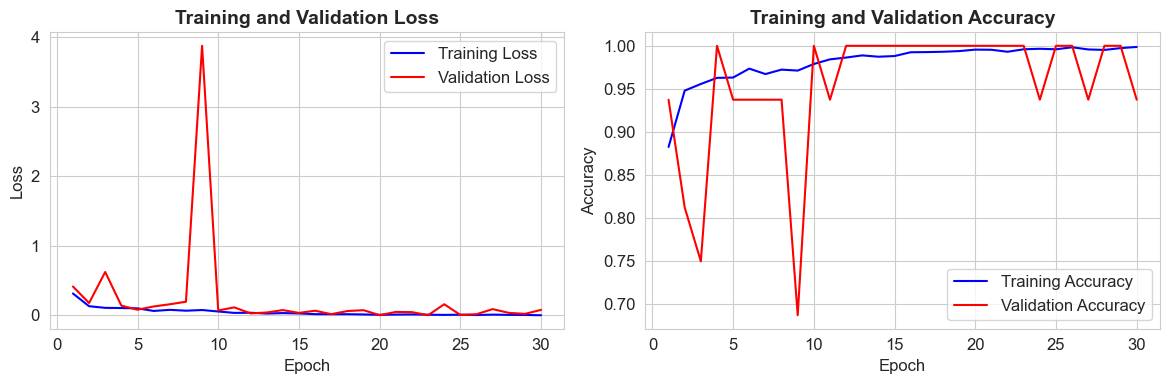

Final Training Loss: 0.0036
Final Validation Loss: 0.0805
Final Training Accuracy: 0.9987
Final Validation Accuracy: 0.9375


In [22]:
def plot_training_history_simple(history):
    """Simpler plot like professor's style."""
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Create figure with 2 subplots (like professor)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot 1: Loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")

# Use the simpler version
print("Plotting simplified training history...")
plot_training_history_simple(history)

## Load Best Model for Evaluation

In [23]:
print("=== LOADING BEST MODEL ===")

try:
    # Load checkpoint
    checkpoint = torch.load('best_pneumonia_model.pth', map_location=device)
    
    # Create new model instance
    best_model = PneumoniaCNN(dropout_rate=0.5).to(device)
    
    # Load trained weights
    best_model.load_state_dict(checkpoint['model_state_dict'])
    
    # Get best epoch info
    best_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['val_acc']
    
    print(f"✓ Best model loaded successfully!")
    print(f"  From epoch: {best_epoch}")
    print(f"  Validation accuracy: {best_val_acc:.4f}")
    
    # Update our current model to the best one
    model = best_model
    
except FileNotFoundError:
    print("⚠️  No saved model found. Using current model.")
    best_epoch = NUM_EPOCHS
    best_val_acc = history['val_acc'][-1]

print(f"Model ready for evaluation.")



=== LOADING BEST MODEL ===


/var/folders/cm/87xs3xzs13qcmdnys2_jq0cc0000gn/T/ipykernel_12366/3987043619.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_pneumonia_model

✓ Best model loaded successfully!
  From epoch: 4
  Validation accuracy: 1.0000
Model ready for evaluation.


## Evaluate on Test Set
Final evaluation on the held-out test set.


FINAL TEST SET EVALUATION
Evaluating on test set...

TEST SET PERFORMANCE
Test Loss: 1.0054
Test Accuracy: 0.7676 (479/624)

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9588    0.3974    0.5619       234
   PNEUMONIA     0.7324    0.9897    0.8419       390

    accuracy                         0.7676       624
   macro avg     0.8456    0.6936    0.7019       624
weighted avg     0.8173    0.7676    0.7369       624



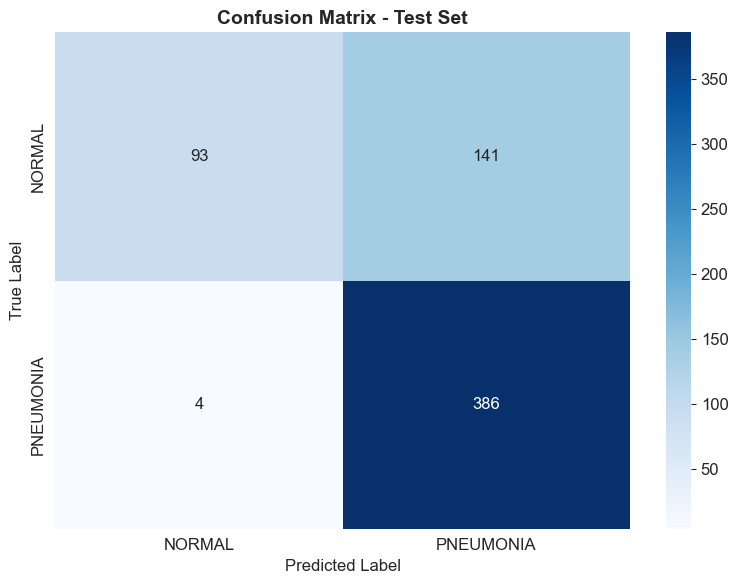


Per-class accuracy:
  NORMAL: 0.3974
  PNEUMONIA: 0.9897


In [24]:
def evaluate_on_test_set(model, test_loader, device):
    """
    Evaluate model on test set and return comprehensive metrics.
    """
    model.eval()
    
    all_labels = []
    all_predictions = []
    all_probabilities = []
    
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    print("Evaluating on test set...")
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Get predictions
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Update counts
            correct = (predicted == labels).sum().item()
            test_correct += correct
            test_total += labels.size(0)
            
            # Store for overall metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    test_loss = test_loss / len(test_loader)
    test_acc = test_correct / test_total
    
    # Classification report
    print("\n" + "="*60)
    print("TEST SET PERFORMANCE")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f} ({test_correct}/{test_total})")
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, 
                               target_names=CLASS_NAMES, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Calculate per-class accuracy
    print("\nPer-class accuracy:")
    for i, class_name in enumerate(CLASS_NAMES):
        class_mask = np.array(all_labels) == i
        if class_mask.any():
            class_acc = np.mean(np.array(all_predictions)[class_mask] == i)
            print(f"  {class_name}: {class_acc:.4f}")
    
    return {
        'test_loss': test_loss,
        'test_acc': test_acc,
        'test_correct': test_correct,
        'test_total': test_total,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities
    }

# Run evaluation
print("\n" + "="*70)
print("FINAL TEST SET EVALUATION")

test_results = evaluate_on_test_set(model, test_loader, device)

## Visualize Model Predictions
Show examples of correct and incorrect predictions.


VISUALIZING MODEL PREDICTIONS


/var/folders/cm/87xs3xzs13qcmdnys2_jq0cc0000gn/T/ipykernel_12366/258631608.py:64: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/cm/87xs3xzs13qcmdnys2_jq0cc0000gn/T/ipykernel_12366/258631608.py:64: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/envs/cs171/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/cs171/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


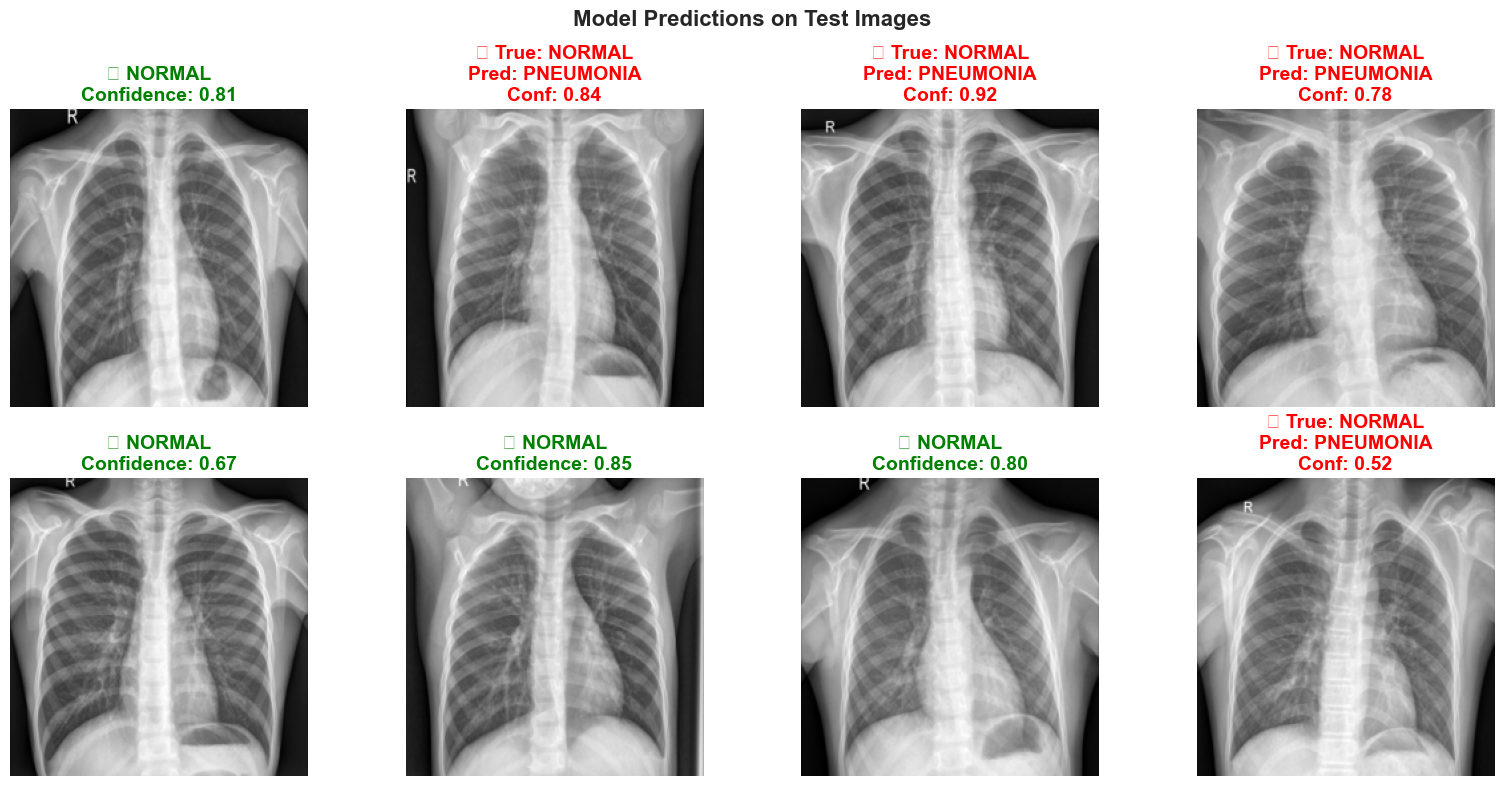

Displayed 8 examples:
  Correct predictions: 4
  Incorrect predictions: 4


In [25]:
def visualize_predictions(model, test_loader, device, num_examples=8):
    """
    Visualize model predictions on test images.
    """
    model.eval()
    
    # Get a batch of test data
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)
    
    # Convert to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predictions = predictions.cpu()
    probabilities = probabilities.cpu()
    
    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i in range(min(num_examples, len(images))):
        # Get image, label, prediction
        img = images[i]
        true_label = labels[i].item()
        pred_label = predictions[i].item()
        prob = probabilities[i][pred_label].item()
        
        # Convert tensor to image format
        img_display = img.numpy().transpose((1, 2, 0))
        img_display = img_display * 0.5 + 0.5  # Unnormalize
        img_display = np.clip(img_display, 0, 1)
        
        # Display image
        axes[i].imshow(img_display[:, :, 0], cmap='gray')
        
        # Set title with color coding
        true_name = CLASS_NAMES[true_label]
        pred_name = CLASS_NAMES[pred_label]
        
        if true_label == pred_label:
            # Correct prediction (green)
            title_color = 'green'
            title = f"✓ {true_name}\nConfidence: {prob:.2f}"
        else:
            # Incorrect prediction (red)
            title_color = 'red'
            title = f"✗ True: {true_name}\nPred: {pred_name}\nConf: {prob:.2f}"
        
        axes[i].set_title(title, color=title_color, fontweight='bold')
        axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(min(num_examples, len(images)), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Model Predictions on Test Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    num_correct = sum(1 for i in range(min(num_examples, len(images))) 
                      if labels[i].item() == predictions[i].item())
    
    print(f"Displayed {min(num_examples, len(images))} examples:")
    print(f"  Correct predictions: {num_correct}")
    print(f"  Incorrect predictions: {min(num_examples, len(images)) - num_correct}")

# Visualize predictions
print("\n" + "="*70)
print("VISUALIZING MODEL PREDICTIONS")
print("="*70)
visualize_predictions(model, test_loader, device, num_examples=8)


## Save Final Results
Save all training results and metrics for analysis.

In [26]:
print("SAVING FINAL RESULTS")

# Create results dictionary
final_results = {
    'training_info': {
        'best_epoch': best_epoch,
        'best_val_accuracy': best_val_acc,
        'test_accuracy': test_results['test_acc'],
        'test_loss': test_results['test_loss'],
        'training_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    
    'model_info': {
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'architecture': str(model).split('\n')[0],  # First line of model string
        'input_size': (3, IMAGE_SIZE, IMAGE_SIZE),
        'num_classes': 2
    },
    
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'dropout_rate': 0.5,
        'optimizer': 'Adam',
        'loss_function': 'CrossEntropyLoss'
    },
    
    'metrics': {
        'confusion_matrix': test_results['confusion_matrix'].tolist(),
        'test_correct': int(test_results['test_correct']),
        'test_total': int(test_results['test_total']),
        'per_class_accuracy': {
            CLASS_NAMES[0]: test_results['confusion_matrix'][0,0] / test_results['confusion_matrix'][0,:].sum(),
            CLASS_NAMES[1]: test_results['confusion_matrix'][1,1] / test_results['confusion_matrix'][1,:].sum()
        }
    },
    
    'training_history': history
}

# Save to JSON file
results_file = 'training_results.json'
with open(results_file, 'w') as f:
    json.dump(final_results, f, indent=2)

print(f" Results saved to '{results_file}'")

# Also save a simple text summary
summary_file = 'model_summary.txt'
with open(summary_file, 'w') as f:
    f.write("="*60 + "\n")
    f.write("PNEUMONIA DETECTION MODEL - TRAINING SUMMARY\n")
    f.write("="*60 + "\n\n")
    
    f.write(f"MODEL PERFORMANCE\n")
    f.write(f"{'='*40}\n")
    f.write(f"Best Validation Accuracy: {best_val_acc:.4f} (epoch {best_epoch})\n")
    f.write(f"Test Accuracy: {test_results['test_acc']:.4f}\n")
    f.write(f"Test Loss: {test_results['test_loss']:.4f}\n")
    f.write(f"Correct/Total: {test_results['test_correct']}/{test_results['test_total']}\n\n")
    
    f.write(f"MODEL ARCHITECTURE\n")
    f.write(f"{'='*40}\n")
    f.write(f"Total Parameters: {total_params:,}\n")
    f.write(f"Trainable Parameters: {trainable_params:,}\n")
    f.write(f"Input Size: 3 x {IMAGE_SIZE} x {IMAGE_SIZE}\n")
    f.write(f"Output Classes: {CLASS_NAMES}\n\n")
    
    f.write(f"TRAINING CONFIGURATION\n")
    f.write(f"{'='*40}\n")
    f.write(f"Epochs: {NUM_EPOCHS}\n")
    f.write(f"Batch Size: {BATCH_SIZE}\n")
    f.write(f"Learning Rate: {LEARNING_RATE}\n")
    f.write(f"Dropout Rate: 0.5\n")
    f.write(f"Optimizer: Adam\n")
    f.write(f"Device: {device}\n")

print(f" Summary saved to '{summary_file}'")

SAVING FINAL RESULTS
 Results saved to 'training_results.json'
 Summary saved to 'model_summary.txt'


## Final Summary and Next Steps

In [27]:
print("="*70)
print("MODEL TRAINING COMPLETE - FINAL SUMMARY")
print("="*70)

print(f"\n PERFORMANCE METRICS:")
print(f"   Best Validation Accuracy: {best_val_acc:.4f}")
print(f"   Test Set Accuracy: {test_results['test_acc']:.4f}")
print(f"   Test Set Loss: {test_results['test_loss']:.4f}")

print(f"\n  MODEL ARCHITECTURE:")
print(f"   Total Parameters: {total_params:,}")
print(f"   Trainable Parameters: {trainable_params:,}")
print(f"   Input: 3-channel {IMAGE_SIZE}x{IMAGE_SIZE} images")
print(f"   Output: {len(CLASS_NAMES)} classes ({', '.join(CLASS_NAMES)})")

print(f"\n FILES CREATED:")
print(f"   1. best_pneumonia_model.pth - Model weights (for inference)")
print(f"   2. training_results.json - All metrics and history")
print(f"   3. model_summary.txt - Human-readable summary")

print(f"\n TRAINING ANALYSIS:")
print(f"   Training epochs: {len(history['train_loss'])}")
print(f"   Final learning rate: {history['learning_rate'][-1]:.6f}")

# Check for overfitting
final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
overfitting_gap = final_train_acc - final_val_acc

print(f"\n🔍 OVERFITTING ANALYSIS:")
print(f"   Final Training Accuracy: {final_train_acc:.4f}")
print(f"   Final Validation Accuracy: {final_val_acc:.4f}")
print(f"   Accuracy Gap: {overfitting_gap:.4f}")

if overfitting_gap > 0.1:
    print(f"     SIGNIFICANT OVERFITTING DETECTED")
    print(f"   Consider: More dropout, data augmentation, or early stopping")
elif overfitting_gap > 0.05:
    print(f"     MODERATE OVERFITTING DETECTED")
    print(f"   Model is learning well but could generalize better")
else:
    print(f"    GOOD GENERALIZATION")
    print(f"   Model performs similarly on training and validation data")

print(f"\n  NEXT STEPS:")
print(f"   1. Share 'best_pneumonia_model.pth' with your partner")
print(f"   2. Your partner can run 'analysis_visualization.ipynb'")
print(f"   3. Prepare your project presentation (Dec 4)")

print(f"\n" + "="*70)
print(" MODEL TRAINING NOTEBOOK COMPLETE")
print("="*70)

MODEL TRAINING COMPLETE - FINAL SUMMARY

 PERFORMANCE METRICS:
   Best Validation Accuracy: 1.0000
   Test Set Accuracy: 0.7676
   Test Set Loss: 1.0054

  MODEL ARCHITECTURE:
   Total Parameters: 26,211,842
   Trainable Parameters: 26,211,842
   Input: 3-channel 224x224 images
   Output: 2 classes (NORMAL, PNEUMONIA)

 FILES CREATED:
   1. best_pneumonia_model.pth - Model weights (for inference)
   2. training_results.json - All metrics and history
   3. model_summary.txt - Human-readable summary

 TRAINING ANALYSIS:
   Training epochs: 30
   Final learning rate: 0.000125

🔍 OVERFITTING ANALYSIS:
   Final Training Accuracy: 0.9987
   Final Validation Accuracy: 0.9375
   Accuracy Gap: 0.0612
     MODERATE OVERFITTING DETECTED
   Model is learning well but could generalize better

  NEXT STEPS:
   1. Share 'best_pneumonia_model.pth' with your partner
   2. Your partner can run 'analysis_visualization.ipynb'
   3. Prepare your project presentation (Dec 4)

 MODEL TRAINING NOTEBOOK COMPLE